In [6]:
import pickle
import jax.numpy as jnp
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update('jax_default_device',jax.devices()[0])

import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
with open('main_results.pkl','rb') as f:
    main_results = pickle.load(f)
    
f1_vals = main_results['f1']
l2_error = main_results['l2']

In [8]:
df_f1 = pd.DataFrame(
	{(run,seed,noise, length): val for (run,seed,noise, length), val in f1_vals.items()},
	index=[0]
).T.reset_index()
df_f1.columns = ['run','seed','noise', 'length', 'f1']
df_f1['recovered'] = (df_f1['f1']==1).astype('int')
# df_f1.groupby(['noise','length'])['recovered'].mean()
df_f1.sort_values(['length','noise','run','seed'])

df_recovery = df_f1.groupby(['noise','length'])['recovered'].mean().unstack(level = 'length')

df_f1 = df_f1.groupby(['noise','length'])['f1'].mean().unstack(level = 'length')

df_recovery = df_recovery.T.loc[::-1]
df_error = pd.DataFrame(
	{(run,seed,noise, length): val for (run,seed,noise, length), val in l2_error.items()},
	index=[0]
).T.reset_index()
df_error.columns = ['run','seed','noise', 'length', 'error']
df_error['error'] = np.minimum(df_error['error'],1.)

df_error = df_error.groupby(['noise','length'])['error'].mean()
df_error = df_error.unstack(level='length')
df_error = df_error.loc[:,::-1].T


In [29]:
error_odr = pd.read_csv('lorenz_mean_errorODR.csv',header = None).T.loc[::-1]
error_odr.columns = df_error.columns
error_odr.index = df_error.index
error_odr

success_odr = pd.read_csv('lorenz_success_rateODR.csv',header = None).T.loc[::-1]
success_odr.columns = df_recovery.columns
success_odr.index = df_recovery.index
success_odr

noise,0.025,0.050,0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250,0.275,0.300,0.325,0.350,0.375,0.400
length,,,,,,,,,,,,,,,,
10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,0.875,1.000,1.000,0.875,0.875,0.875,0.500
9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.875,0.625,0.625
8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,0.875,0.875,0.875,0.875,0.750,0.500,0.500
7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,0.875,1.000,0.875,0.750,0.125,0.375,0.500
6.0,1.0,1.0,1.0,1.0,1.0,1.0,0.875,0.875,0.750,0.750,0.625,0.500,0.625,0.250,0.250,0.250
5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,0.875,0.875,0.625,0.375,0.250,0.125,0.000,0.000,0.125
4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.750,0.625,0.250,0.125,0.125,0.000,0.000,0.000,0.000,0.000


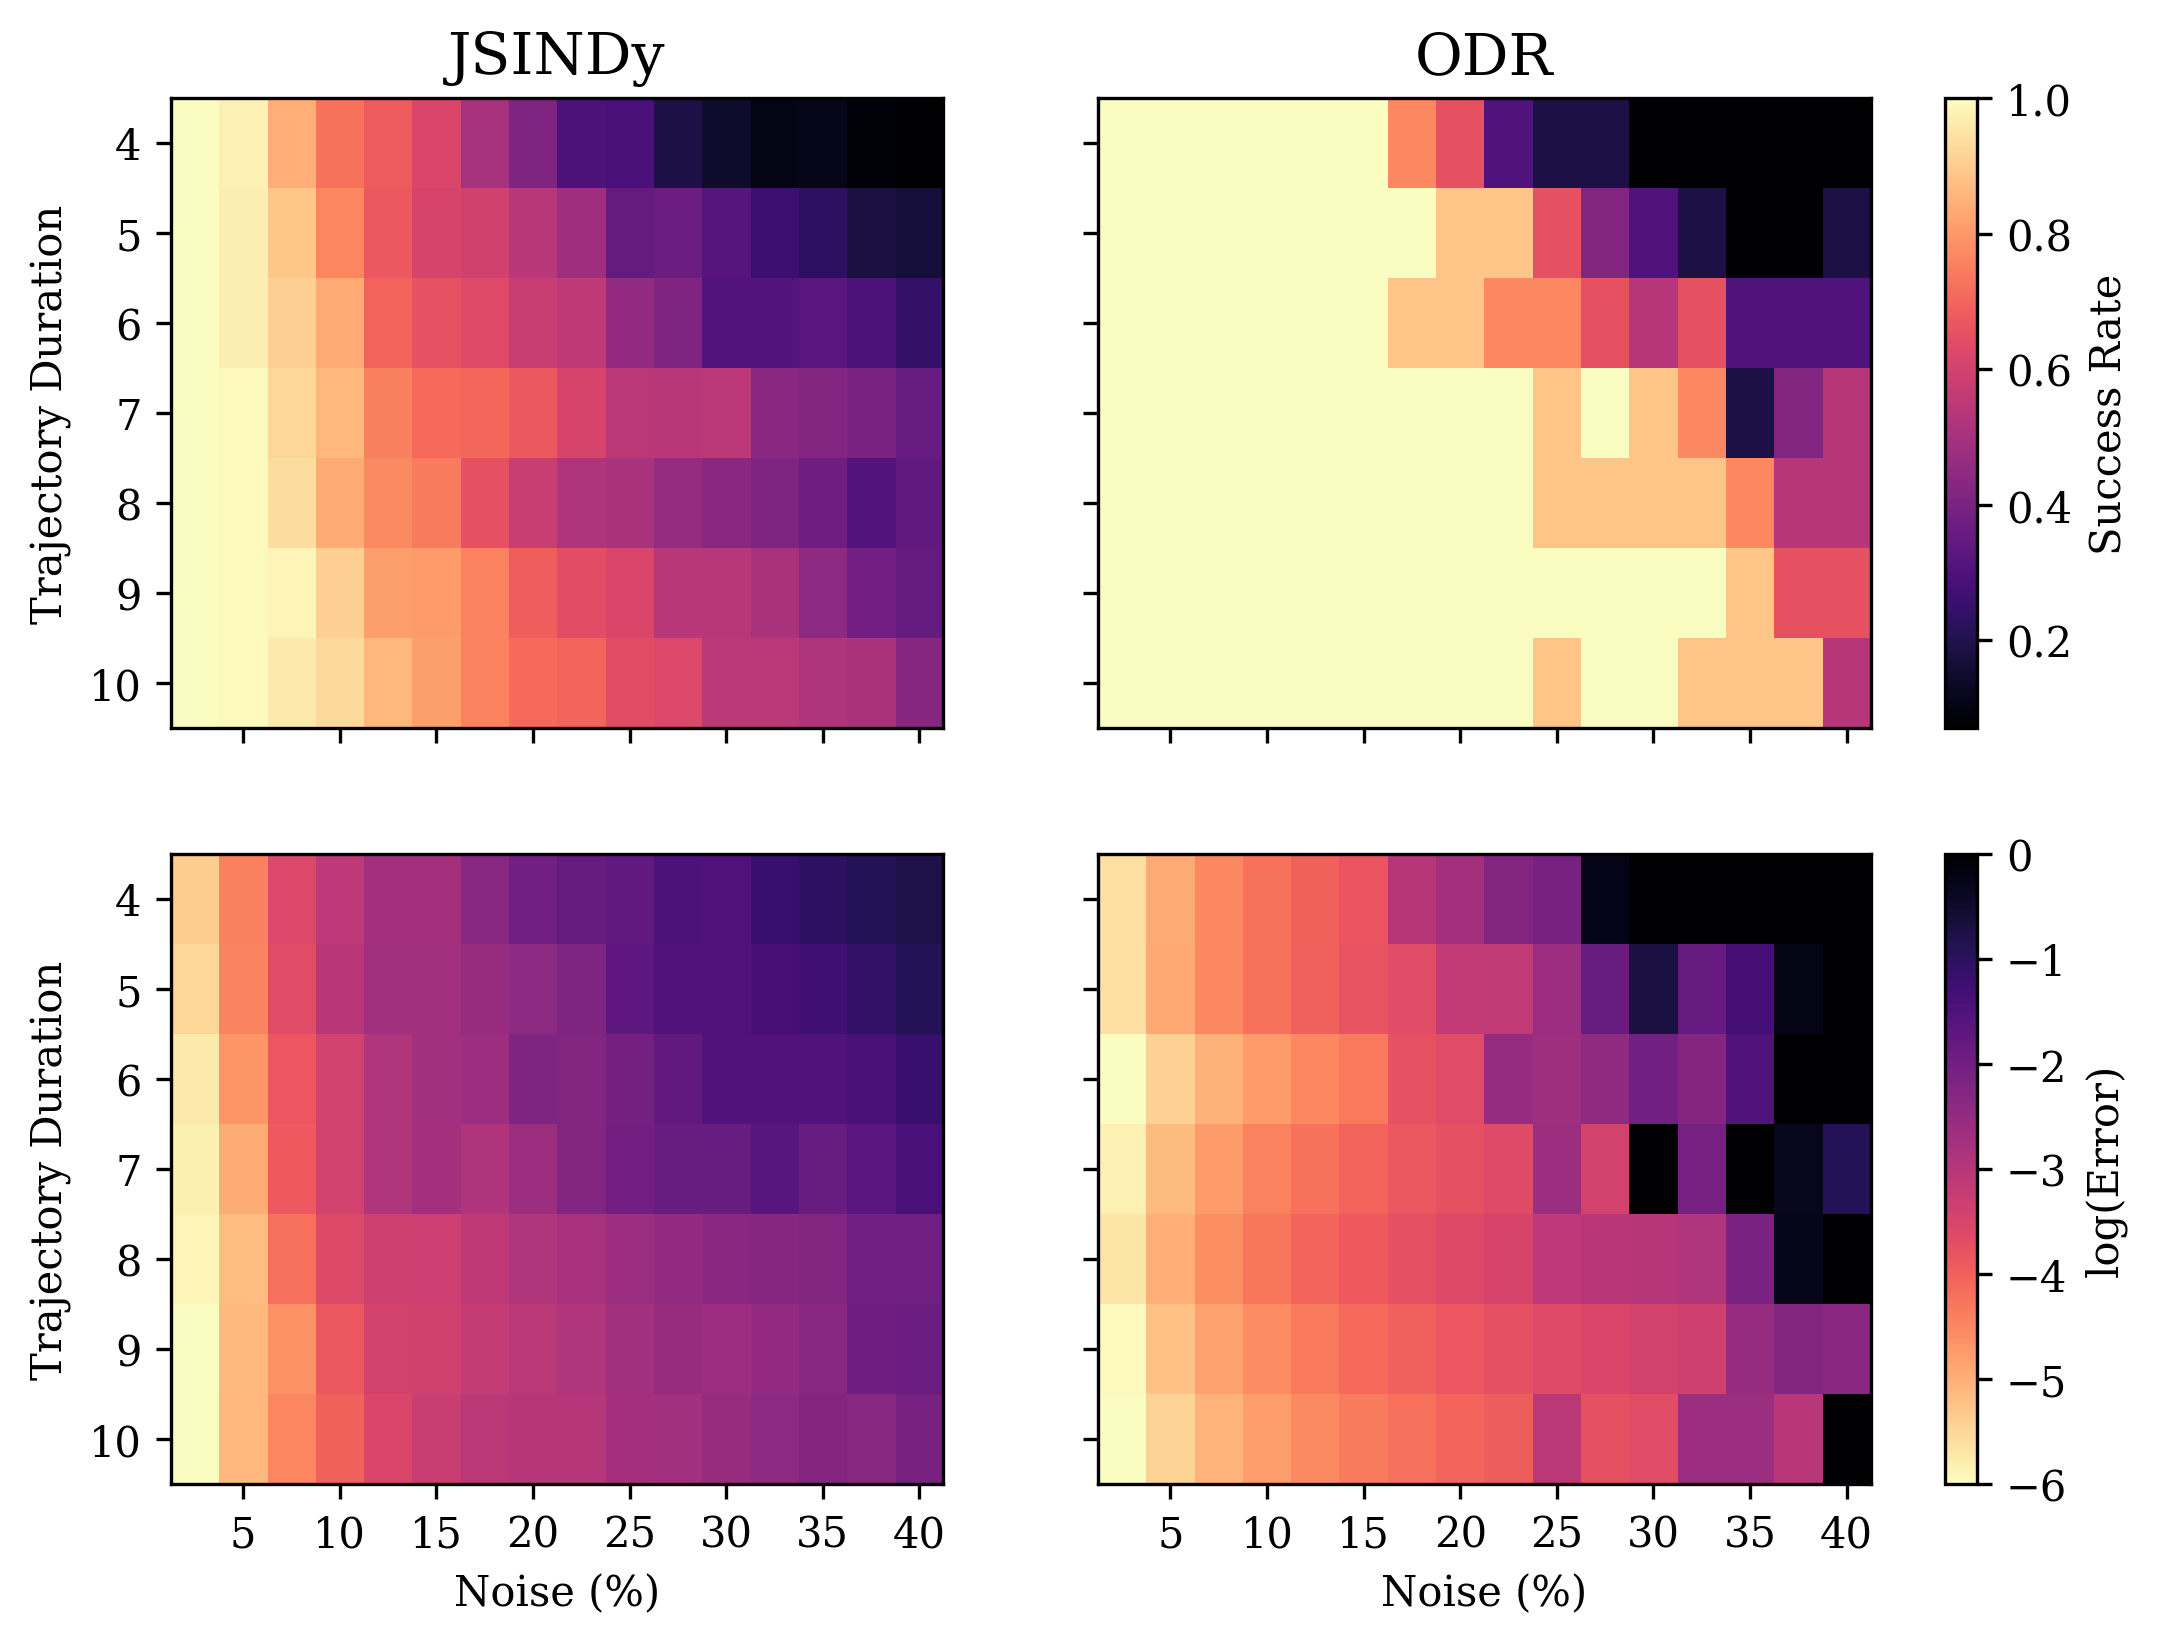

: 

In [ ]:
plt.style.use('default')
plt.rcParams["font.family"] = 'serif'
cmap = 'magma'

fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=300,
                         sharex=True, sharey=True)

# ------------------------------------------------------------------
# Helper stuff
# ------------------------------------------------------------------
noise_cols = df_recovery.columns
traj_idx   = df_recovery.index
skip = 2

def set_ticks(ax):
    ax.set_xticks(np.arange(len(noise_cols))[1::skip])
    ax.set_xticklabels([f"{int(c*100)}" for c in noise_cols][1::skip])
    ax.set_yticks(np.arange(len(traj_idx)))
    ax.set_yticklabels([f"{int(t)}" for t in traj_idx])

# ------------------------------------------------------------------
# ROW 0: Exact support recovery  (metric)
#   Col 0: our method
#   Col 1: ODR
# ------------------------------------------------------------------
im_recovery_ours = axes[0, 0].imshow(
    df_recovery.values, aspect='auto', origin='lower', cmap=cmap
)
set_ticks(axes[0, 0])
axes[0, 0].set_title("JSINDy", size=14)

im_recovery_odr = axes[0, 1].imshow(
    success_odr, aspect='auto', origin='lower', cmap=cmap
)
set_ticks(axes[0, 1])
axes[0, 1].set_title("ODR", size=14)

# ------------------------------------------------------------------
# ROW 1: Relative coefficient error (metric)
#   Col 0: our method
#   Col 1: ODR
# ------------------------------------------------------------------
im_error_ours = axes[1, 0].imshow(
    np.log(df_error.values), aspect='auto', origin='lower',
    vmin=-6, vmax=0, cmap=cmap + "_r"
)
set_ticks(axes[1, 0])

im_error_odr = axes[1, 1].imshow(
    np.log(error_odr), aspect='auto', origin='lower',
    vmin=-6, vmax=0, cmap=cmap + "_r"
)
set_ticks(axes[1, 1])

# ------------------------------------------------------------------
# Common axis labels
# ------------------------------------------------------------------
for ax in axes[:, 0]:
    ax.set_ylabel("Trajectory Duration")

for ax in axes[1, :]:
    ax.set_xlabel("Noise (%)")

# ------------------------------------------------------------------
# Row labels (metrics) to make layout obvious
# ------------------------------------------------------------------
# fig.text(0.03, 0.75, "Exact Support Success Rate",
#          va='center', ha='center', rotation='vertical', fontsize=10)
# fig.text(0.03, 0.25, "Relative Coefficient Error",
#          va='center', ha='center', rotation='vertical', fontsize=10)

# Column labels (models)
# fig.text(0.5, 0.95, "Our method vs ODR", ha='center', fontsize=16)
# fig.text(0.30, 0.90, "Our method", ha='center', fontsize=13)
# fig.text(0.70, 0.90, "ODR", ha='center', fontsize=13)

# ------------------------------------------------------------------
# Shared colorbars by row (consistent scales)
# ------------------------------------------------------------------
cbar0 = fig.colorbar(im_recovery_ours, ax=axes[0, :],
                     fraction=0.046, pad=0.04)
cbar0.set_label("Success Rate")

cbar1 = fig.colorbar(im_error_ours, ax=axes[1, :],
                     fraction=0.046, pad=0.04,
                     ticks=np.arange(-6, 1))
cbar1.set_label("log(Error)")

# fig.tight_layout(rect=[0.08, 0.03, 1.0, 0.90])
# fig.savefig("lorenz_benchmark.pdf")
# plt.show()
